# Analyzing module-wise energies for different architectures

In [82]:
import sys
sys.path.append('../')

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils.data_utils import preprocess_and_normalize_energy_data, parse_codecarbon_output
from torchvision import models
from utils.architecture_utils import get_modules_from_architecture
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
architectures_dict = {
    'alexnet': models.alexnet(weights=None),
    'vgg13': models.vgg13(weights=None),
    'vgg11': models.vgg11(weights=None),
    'vgg16': models.vgg16(weights=None)
}

# Loading and aggregating the data

In [85]:
d1 = parse_codecarbon_output(
    '../data/architectures/00_architectures-layerwise-raw.csv',
    False,
    ('../data/architectures/00_architectures-layerwise-slurm-log.out','architectures',False,3)
)
print("dataset shape:", d1.shape)

Dropped observations with the following indices: [83, 267, 385, 451, 605, 632, 818, 832, 989, 1175, 1269, 1366, 1500, 1730, 1752, 1942, 1958, 2130, 2184, 2316, 2410, 2506, 2639, 2694, 2878, 3062, 3082, 3239, 3300, 3424, 3514, 3733]
dataset shape: (3748, 35)


In [86]:
d2 = parse_codecarbon_output(
    '../data/architectures/01_architectures-layerwise-raw.csv',
    False,
    ('../data/architectures/01_architectures-layerwise-slurm-log.out','architectures',False,3)
)
print("dataset shape:", d2.shape)

Dropped observations with the following indices: [68, 199, 259, 430, 450, 642, 661, 824, 882, 1109, 1200, 1387, 1561, 1571, 1747, 1930, 1999]
dataset shape: (2053, 35)


In [87]:
df_unnormalized = pd.concat([d1,d2])
df = preprocess_and_normalize_energy_data(
    df_unnormalized,
    ['module','batch_size','architecture','layer_idx'],
    aggregate=True
)
df["layer_idx"] = pd.to_numeric(df['layer_idx'])
df.head(n=10)

Final shape of data set: (1840, 25)


,module,batch_size,architecture,layer_idx,duration,emissions,emissions_rate,cpu_power,gpu_power,ram_power,...,cloud_provider,cloud_region,cpu_count,gpu_count,longitude,latitude,ram_total_size,rep_no,macs,forward_passes
0,VGG,194,vgg16,0,86.188563,0.002758,0.032003,75.640754,30.349667,288.75,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,3.007684e+12,1.000000
1,Conv2d,194,vgg16,1,30.621151,0.000979,0.031967,73.225084,30.504333,288.75,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,1.744359e+10,9.000000
2,ReLU,194,vgg16,2,30.218282,0.001051,0.034779,76.657830,30.316333,288.75,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,6.229852e+08,148.666667
3,Conv2d,194,vgg16,3,36.407569,0.001165,0.031999,73.983227,30.390667,288.75,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,3.594625e+11,3.000000
4,ReLU,194,vgg16,4,30.136231,0.001002,0.033246,79.940490,30.748000,288.75,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,6.229852e+08,148.000000
5,MaxPool2d,194,vgg16,5,32.946785,0.001057,0.032075,75.069477,30.142333,288.75,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,3.114926e+08,10.000000
6,Conv2d,194,vgg16,6,32.311439,0.001036,0.032058,75.508507,30.526333,288.75,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,1.797312e+11,6.000000
7,ReLU,194,vgg16,7,30.087511,0.000976,0.032441,80.015973,30.388000,288.75,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,3.114926e+08,298.000000
8,Conv2d,194,vgg16,8,38.767998,0.001243,0.032052,75.120991,30.690333,288.75,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,3.591510e+11,4.000000
9,ReLU,194,vgg16,9,30.061465,0.000976,0.032474,80.027298,30.325333,288.75,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,3.114926e+08,298.666667


## Ensuring that module-wise observations are complete for every architecture and batch-size

In [88]:
for a in df.architecture.unique():
    sub = df.loc[df.architecture == a]
    num_modules_a = len(get_modules_from_architecture(architectures_dict[a]))
    for b in sub.batch_size.unique():
        sub_b = sub.loc[sub.batch_size == b]
        if num_modules_a+1 - len(sub_b) != 0:
            print(f"removing all observations from {a} with batch_size {b}")
            df = df.drop(index=sub_b.index)
print("Final data-shape: ", df.shape)

Final data-shape:  (1840, 25)


# Analysis

In [89]:
# compute % contribution
module_wise_contributions_by_architecture = pd.DataFrame(columns=['architecture','module','batch_size','cpu_energy','percent_contribution'])
for a in df.architecture.unique():
    # subset data by architecture
    sub = df.loc[df.architecture == a]
    total_measured_energies = []
    total_agg_energies = []
    for b in sub.batch_size.unique():
        # subset data by batch_size
        sub_b = sub.loc[sub.batch_size == b]
        # get energy from complete architecture run
        test = sub_b.loc[sub_b.layer_idx == 0]
        test2 = sub_b.loc[sub_b.layer_idx == 0].cpu_energy
        total_measured_energy = sub_b.loc[sub_b.layer_idx == 0].cpu_energy.item()

        # subset only data from individual modules of architecture
        sub_b = sub_b.loc[sub_b.layer_idx != 0]
        # compute empirical total energy from complete architecture run by summing up modules
        sub_b = sub_b.groupby(['architecture','batch_size','module'])['cpu_energy'].sum().reset_index()
        total_agg_energy = sum(sub_b.cpu_energy)
        # compute % contribution of module to total energy consumption
        sub_b["percent_contribution"] = round(sub_b.cpu_energy / total_agg_energy * 100, 2)
        module_wise_contributions_by_architecture = pd.concat([module_wise_contributions_by_architecture, sub_b], ignore_index=True)
        # store values
        total_agg_energies.append(total_agg_energy)
        total_measured_energies.append(total_measured_energy)
    # print avg energies; compare energy when running the full architecture vs summing the energy over the individual modules
    print(f"{a}: avg. total-measured-energy: {np.round(np.mean(total_measured_energies),10)}, avg. total-agg-energy: {np.round(np.mean(total_agg_energies),10)}, resulting deviation: {abs(np.round(np.mean([(b - a) / b for a, b in zip(total_measured_energies, total_agg_energies)]),2)*100)}%")

vgg16: avg. total-measured-energy: 0.0012908125, avg. total-agg-energy: 0.0012983243, resulting deviation: 1.0%
alexnet: avg. total-measured-energy: 4.81891e-05, avg. total-agg-energy: 4.8686e-05, resulting deviation: 0.0%
vgg11: avg. total-measured-energy: 0.000478324, avg. total-agg-energy: 0.0004838759, resulting deviation: 1.0%
vgg13: avg. total-measured-energy: 0.0009647818, avg. total-agg-energy: 0.000971957, resulting deviation: 1.0%


# Plotting

black line shows deviations between batch-sizes


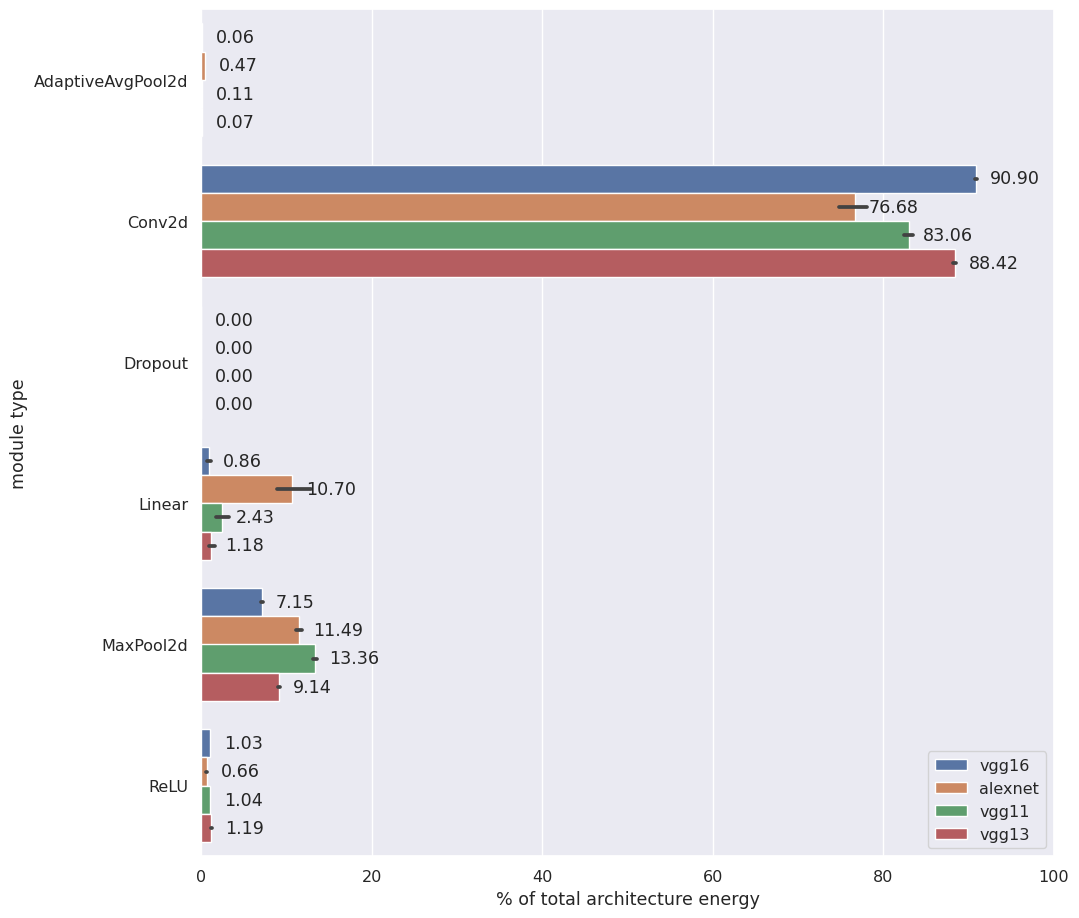

In [90]:
plt.figure(figsize=(11,11))
sns.set(font_scale=1.05)
g = sns.barplot(data=module_wise_contributions_by_architecture, x="percent_contribution",y="module",hue="architecture")
for i in range(0,len(df.architecture.unique())):
    g.bar_label(g.containers[i], padding=10, fmt="%0.2f")

g.set_xlim(0, 100)
plt.legend(loc="lower right")
plt.ylabel("module type")
plt.xlabel("% of total architecture energy")
print("black line shows deviations between batch-sizes")

Text(0, 0.5, '% of total architecture energy')

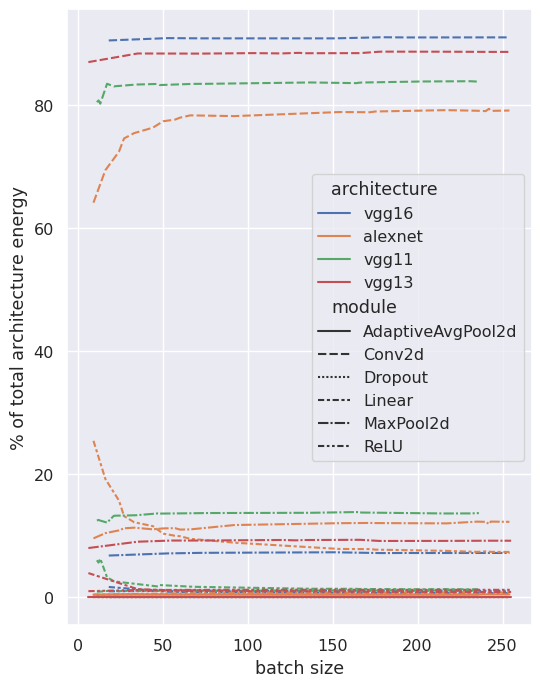

In [91]:
plt.figure(figsize=(6,8))
sns.lineplot(data=module_wise_contributions_by_architecture, x="batch_size", y="percent_contribution", hue="architecture",style="module")
plt.xlabel("batch size")
plt.ylabel("% of total architecture energy")